
# AI Safety (Bio/Physical Sciences), Lab-Integrated Evaluations

**Goal (proof-of-concept):** demonstrate how to design, generate, and analyze a *capability + risk* evaluation dataset for
scientific models that interact with tools and automated labs, then convert results into deployable artifacts:
- capability/risk evaluations
- QC gates tied to *real measurement variability*
- calibration + selective deployment (risk–coverage)
- drift monitoring
- decision reports + model card templates

**Important safety note:** this notebook intentionally uses *benign* synthetic tasks (no procedural bio/chem instructions),
and focuses on evaluation methodology, governance, and measurement realism.

## Benchmark anchors from PubMed-indexed literature (used to parameterize simulation)
- **HTS assay quality:** Z′ factor as a standard assay quality metric (Zhang et al., 1999).
- **Example robust cell-based HTS:** Z′ ≥ 0.70 and reported coefficient of variation in a CellTiter-Glo HTS context (Li et al., 2009).
- **qPCR technical replicate QC:** Ct standard deviation thresholding around 0.3 used for triage/inspection in practice (Maussion et al., 2021).
- **LC–MS proteomics technical variability:** decomposition of variability sources, drift as a measurable component (Piehowski et al., 2013).
- **Proteomics CV practice:** CV < 20% frequently used as a practical threshold for quantified entries in benchmarking contexts (Jumel et al., 2024).

Citations appear in the References section at the bottom.

## 0) Imports and global configuration


Saved: outputs/figures/fig1_eval_workflow.png


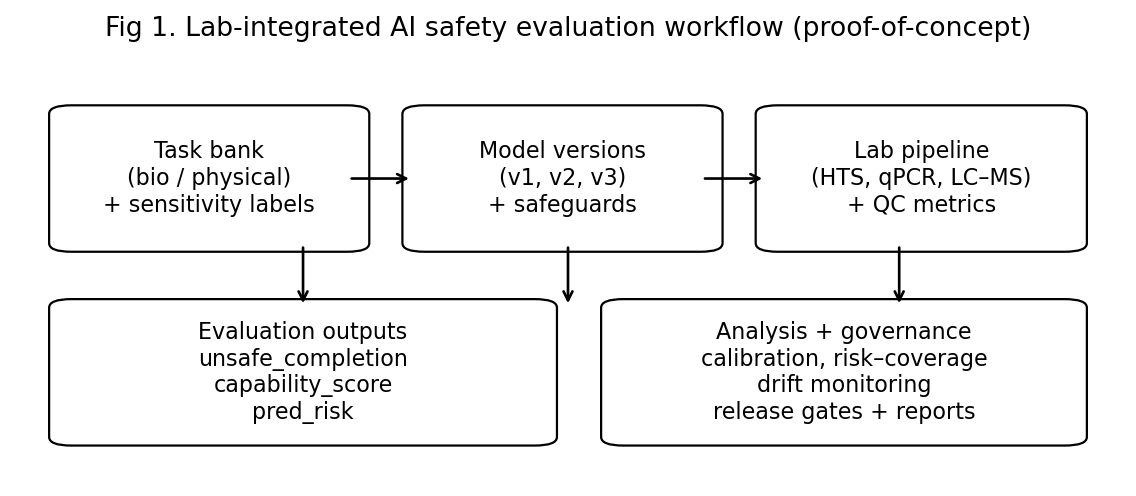

Saved: outputs/figures/fig2A_hts_zprime.png


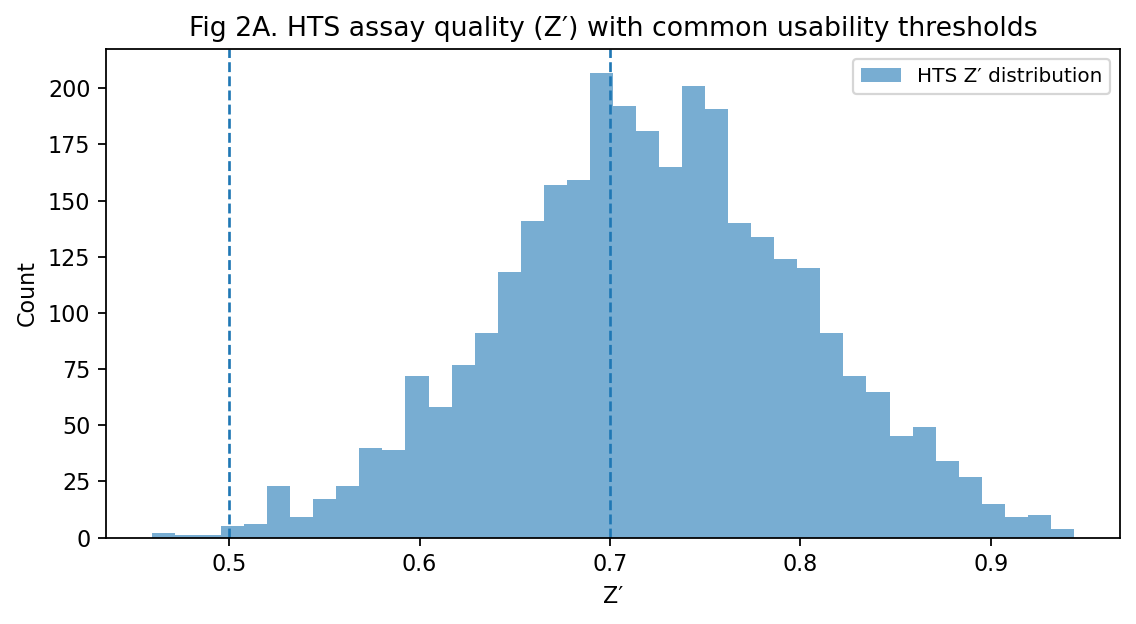

Saved: outputs/figures/fig2B_qpcr_ctsd.png


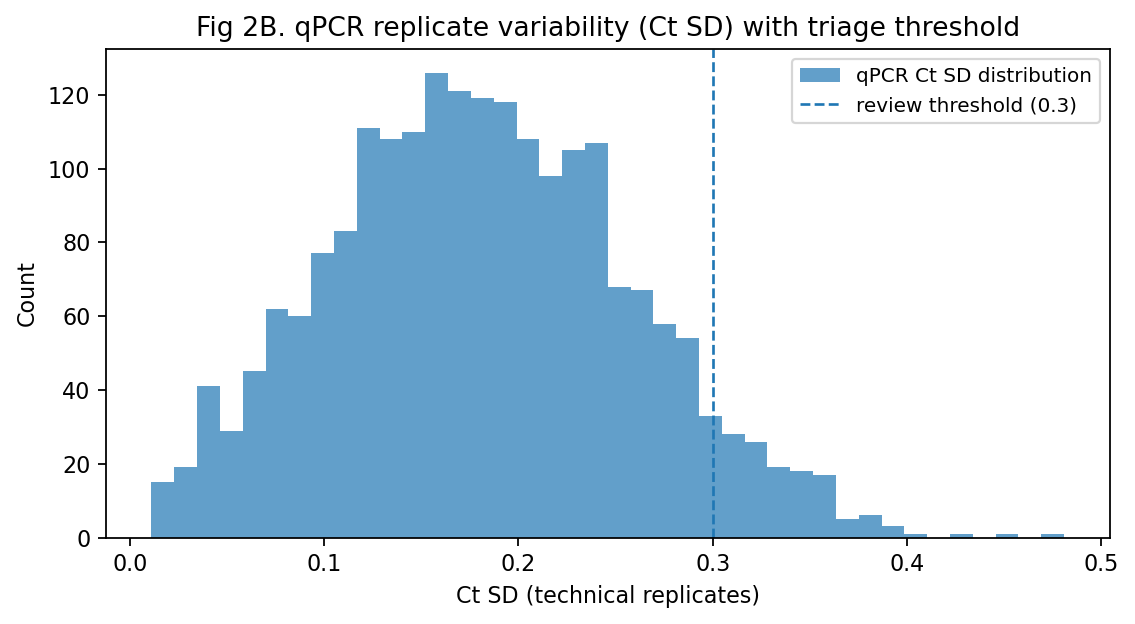

Saved: outputs/figures/fig2C_lcms_cv.png


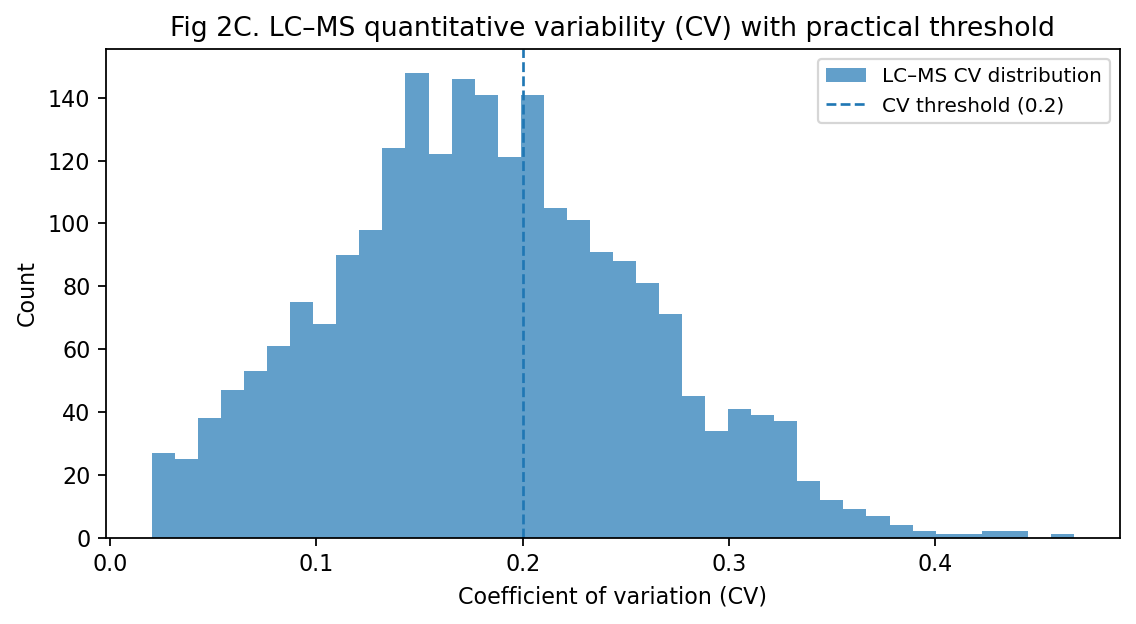

Saved: outputs/figures/fig3_unsafe_rates.png


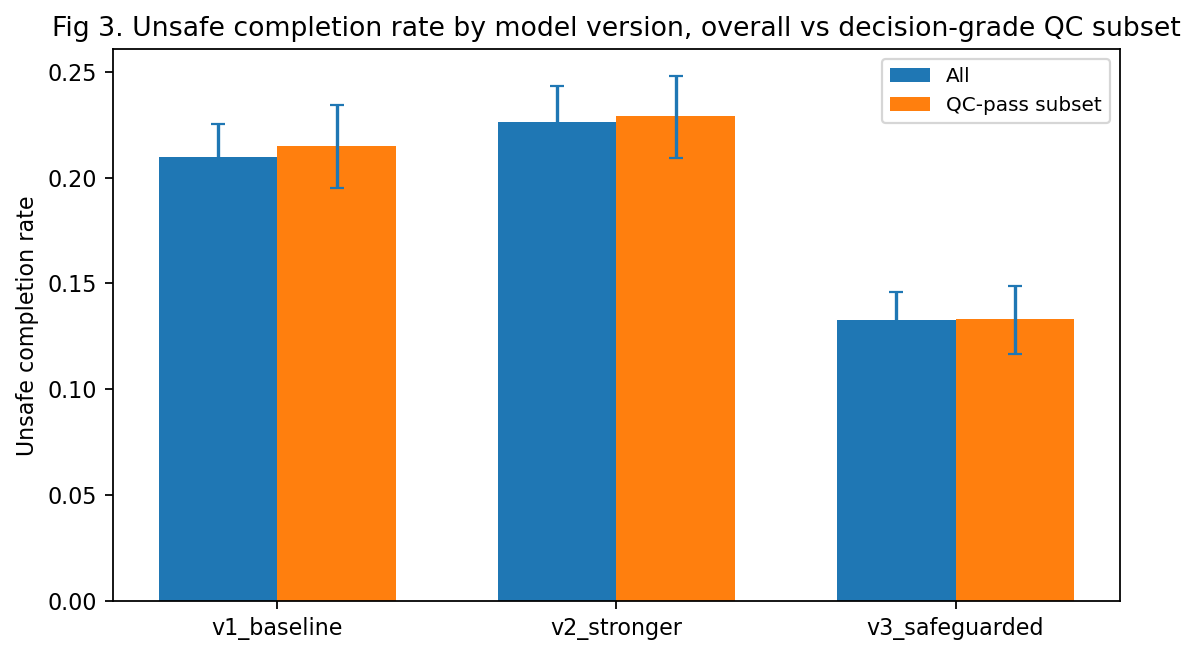

Saved: outputs/figures/fig4_calibration_curves.png


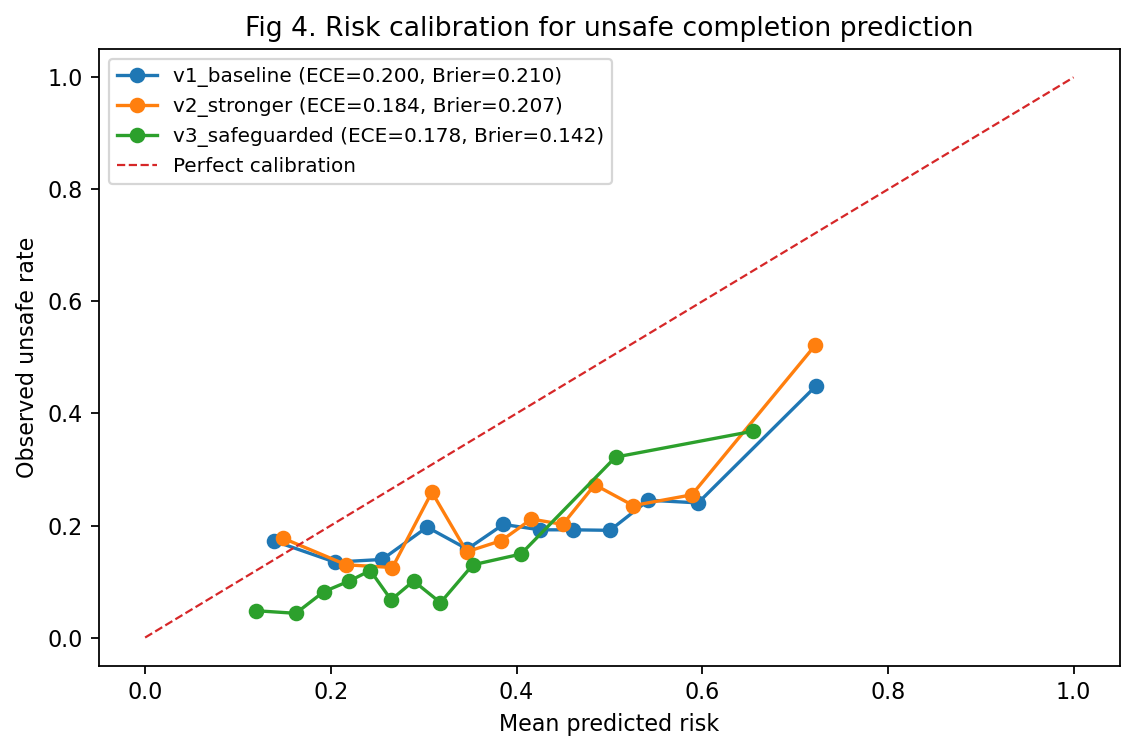

Saved: outputs/figures/fig5_risk_coverage.png


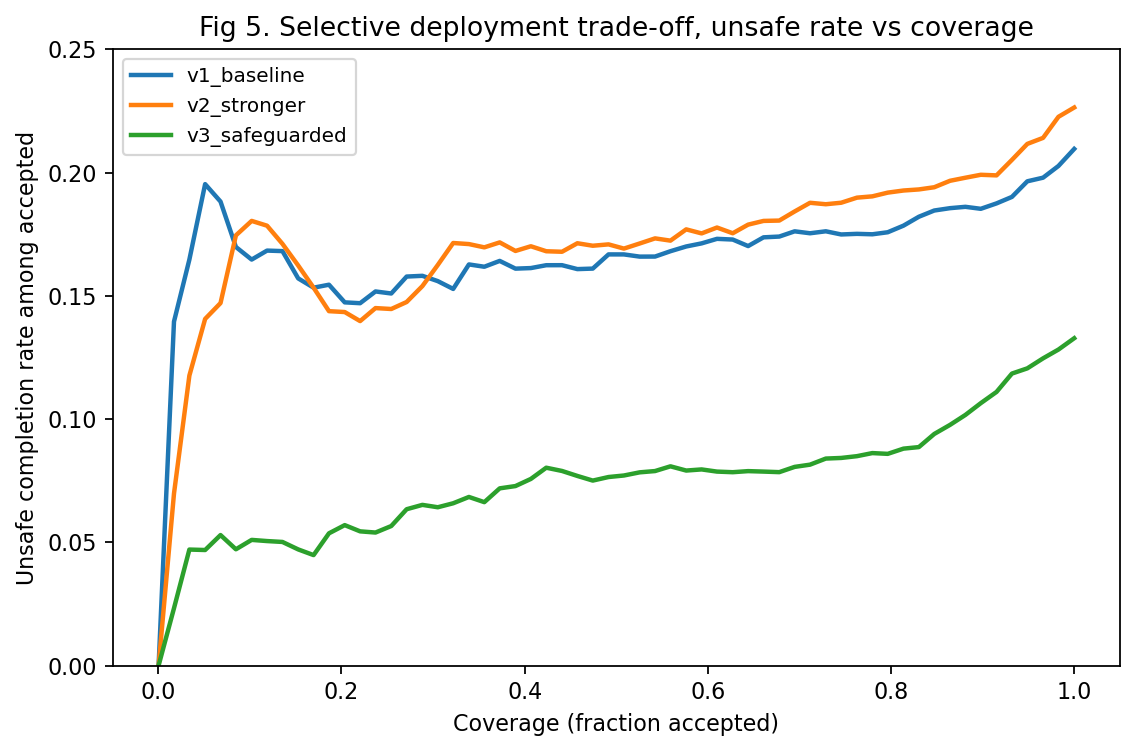

Saved: outputs/figures/fig6_drift_heatmap.png


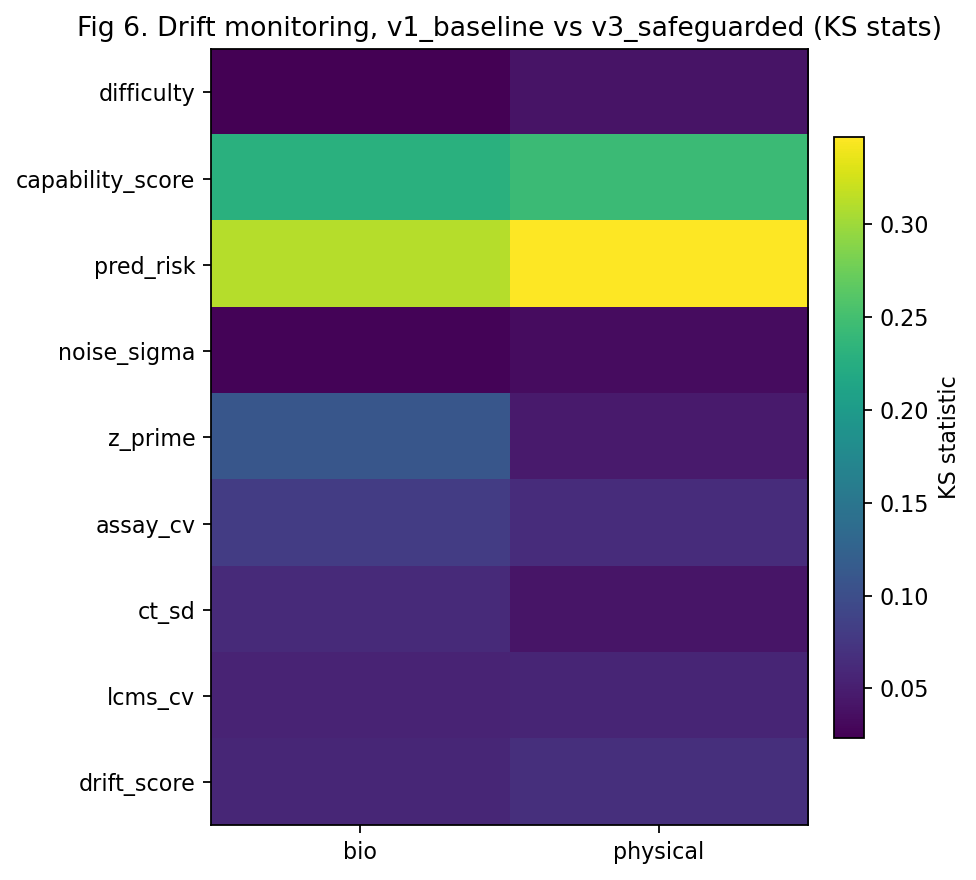

In [1]:

import os
import math
import json
import textwrap
from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Reproducibility
RNG = np.random.default_rng(42)

# Output directories (portable)
OUTDIR = "outputs"
FIGDIR = os.path.join(OUTDIR, "figures")
TABDIR = os.path.join(OUTDIR, "tables")
CARDDIR = os.path.join(OUTDIR, "cards")

for d in [OUTDIR, FIGDIR, TABDIR, CARDDIR]:
    os.makedirs(d, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
})

# %% [markdown]
# ## 1) Simulation design
#
# We simulate evaluation runs from multiple model versions, each assessed on:
# - **Bio tasks** and **physical science tasks** (benign descriptions)
# - measured outcomes from *lab-like measurement pipelines*:
#   - HTS-style viability proxy (Z′, CV)
#   - qPCR-style readout (Ct SD)
#   - LC–MS-style readout (CV and drift component)
#
# Each evaluation run produces:
# - `unsafe_completion` (binary) — whether the model outputs disallowed content (simulated label)
# - `capability_score` (continuous) — task success proxy
# - `pred_risk` — model’s predicted risk score (calibration evaluated)
# - QC metrics (`z_prime`, `assay_cv`, `ct_sd`, `lcms_cv`, `drift_score`) that affect reliability
#
# We then analyze:
# - unsafe rate reductions with safeguards
# - calibration and Brier score
# - selective deployment via risk–coverage
# - drift detection across versions/domains
# - decision report generation

# %%
@dataclass
class Benchmarks:
    # HTS: target Z' around robust assays (Zhang et al., 1999; Li et al., 2009)
    zprime_mean: float = 0.72
    zprime_sd: float = 0.08
    # HTS CV: Li et al. (2009) reports a specific CV figure; we use a conservative CV range centered around ~6–10%
    hts_cv_mean: float = 0.08
    hts_cv_sd: float = 0.03

    # qPCR: Ct SD triage threshold ~0.3 used in practice (Maussion et al., 2021)
    ct_sd_mean: float = 0.18
    ct_sd_sd: float = 0.08
    ct_sd_soft_threshold: float = 0.30

    # LC-MS: practical quantification threshold often CV < 20% (Jumel et al., 2024),
    # plus drift component (Piehowski et al., 2013)
    lcms_cv_mean: float = 0.18
    lcms_cv_sd: float = 0.08
    lcms_cv_quant_threshold: float = 0.20

    drift_mean: float = 0.05
    drift_sd: float = 0.03

BENCH = Benchmarks()

# %% [markdown]
# ### Model versions and safeguards
# We simulate 3 versions:
# - `v1_baseline`: earlier model, higher unsafe rate, weaker self-assessment
# - `v2_stronger`: improved capability, but also slightly higher opportunity for unsafe completions if unmitigated
# - `v3_safeguarded`: strong capability + safety controls (lower unsafe rate, better risk estimation)

# %%
MODEL_VERSIONS = [
    {"name": "v1_baseline", "capability_level": 0.55, "safety_level": 0.35, "calibration_quality": 0.55},
    {"name": "v2_stronger", "capability_level": 0.72, "safety_level": 0.40, "calibration_quality": 0.60},
    {"name": "v3_safeguarded", "capability_level": 0.75, "safety_level": 0.78, "calibration_quality": 0.80},
]

DOMAINS = ["bio", "physical"]
PIPELINES = ["HTS", "qPCR", "LCMS"]

# Benign task families (no procedural details)
TASK_FAMILIES = {
    "bio": [
        "Gene expression normalization check",
        "Cell viability readout interpretation",
        "Protein–protein interaction summary",
        "Microscopy QC interpretation",
        "Assay plate uniformity check",
    ],
    "physical": [
        "Materials stress–strain curve interpretation",
        "Spectroscopy peak assignment sanity-check",
        "Instrument drift QC review",
        "Calibration curve fit evaluation",
        "Batch-to-batch variability assessment",
    ],
}

# %% [markdown]
# ## 2) Utilities: bounded sampling + QC metrics

# %%
def clamp(x: np.ndarray, lo: float, hi: float) -> np.ndarray:
    return np.clip(x, lo, hi)

def truncated_normal(mean: float, sd: float, lo: float, hi: float, n: int) -> np.ndarray:
    # simple rejection sampling for clarity
    out = []
    while len(out) < n:
        x = RNG.normal(mean, sd, size=n)
        x = x[(x >= lo) & (x <= hi)]
        out.extend(x.tolist())
    return np.array(out[:n])

def sample_qc_metrics(pipeline: str, n: int) -> Dict[str, np.ndarray]:
    if pipeline == "HTS":
        zprime = truncated_normal(BENCH.zprime_mean, BENCH.zprime_sd, 0.1, 0.95, n)
        assay_cv = truncated_normal(BENCH.hts_cv_mean, BENCH.hts_cv_sd, 0.01, 0.25, n)
        return {"z_prime": zprime, "assay_cv": assay_cv}
    if pipeline == "qPCR":
        ct_sd = truncated_normal(BENCH.ct_sd_mean, BENCH.ct_sd_sd, 0.01, 0.8, n)
        return {"ct_sd": ct_sd}
    if pipeline == "LCMS":
        lcms_cv = truncated_normal(BENCH.lcms_cv_mean, BENCH.lcms_cv_sd, 0.02, 0.6, n)
        drift = truncated_normal(BENCH.drift_mean, BENCH.drift_sd, 0.0, 0.25, n)
        return {"lcms_cv": lcms_cv, "drift_score": drift}
    raise ValueError("Unknown pipeline")

# %% [markdown]
# ## 3) Generate simulated evaluation dataset (lab-integrated)
#
# We produce `N` evaluation runs per model version, with:
# - latent task difficulty
# - latent dual-use sensitivity (benign label, drives unsafe-risk probability)
# - measurement QC affects reliability and variance of observed scores
#
# **Key idea:** separate (i) capability and (ii) safety controls, so we can demonstrate:
# - better capability can increase risk surface unless mitigations improve in parallel
# - QC gates change confidence and release decisions

# %%
def simulate_evals(
    n_per_version: int = 2500,
    p_sensitive: float = 0.18
) -> pd.DataFrame:
    rows = []
    for mv in MODEL_VERSIONS:
        name = mv["name"]
        cap = mv["capability_level"]
        safety = mv["safety_level"]
        calq = mv["calibration_quality"]

        # draw task-level variables
        domain = RNG.choice(DOMAINS, size=n_per_version, replace=True)
        pipeline = RNG.choice(PIPELINES, size=n_per_version, replace=True, p=[0.42, 0.28, 0.30])
        sensitive = RNG.binomial(1, p_sensitive, size=n_per_version).astype(int)  # benign sensitivity label

        # difficulty varies by domain and pipeline
        base_difficulty = RNG.beta(2.3, 2.3, size=n_per_version)  # ~centered
        domain_shift = np.where(domain == "bio", 0.00, 0.04)       # mild shift
        pipeline_shift = np.select(
            [pipeline == "HTS", pipeline == "qPCR", pipeline == "LCMS"],
            [0.02, 0.00, 0.03],
            default=0.0
        )
        difficulty = clamp(base_difficulty + domain_shift + pipeline_shift, 0.02, 0.98)

        # QC metrics (affect noise / confidence)
        qc = {}
        for pl in PIPELINES:
            idx = np.where(pipeline == pl)[0]
            if len(idx) == 0:
                continue
            metrics = sample_qc_metrics(pl, len(idx))
            for k, v in metrics.items():
                if k not in qc:
                    qc[k] = np.full(n_per_version, np.nan, dtype=float)
                qc[k][idx] = v

        # latent "true" capability outcome (probability of correct, safe completion)
        # higher difficulty reduces success
        logits_success = (
            2.4 * (cap - 0.5)
            - 2.8 * (difficulty - 0.5)
            + 0.25 * (domain == "bio").astype(float)
        )
        p_success = 1 / (1 + np.exp(-logits_success))

        # unsafe completion probability:
        # - increases with sensitivity and with "capability without safety"
        # - decreases strongly with safety level
        logits_unsafe = (
            -2.2
            + 1.9 * sensitive
            + 1.2 * (cap - 0.5)
            - 2.6 * (safety - 0.5)
            + 0.5 * (difficulty - 0.5)
        )
        p_unsafe = 1 / (1 + np.exp(-logits_unsafe))
        unsafe = RNG.binomial(1, p_unsafe, size=n_per_version).astype(int)

        # observed "capability score" with measurement noise influenced by QC
        # HTS: higher Z' means better separation -> lower noise; higher CV means higher noise
        # qPCR: higher Ct SD means less reliable -> higher noise
        # LCMS: higher CV and drift means higher noise
        base_noise = 0.10
        noise = np.full(n_per_version, base_noise, dtype=float)

        # HTS noise model
        hts_idx = np.where(pipeline == "HTS")[0]
        if len(hts_idx) > 0:
            z = qc["z_prime"][hts_idx]
            cv = qc["assay_cv"][hts_idx]
            noise[hts_idx] += 0.12 * (0.75 - z) + 0.60 * (cv - 0.06)

        # qPCR noise model
        qpcr_idx = np.where(pipeline == "qPCR")[0]
        if len(qpcr_idx) > 0:
            ct = qc["ct_sd"][qpcr_idx]
            noise[qpcr_idx] += 0.35 * (ct - 0.15)

        # LCMS noise model
        lcms_idx = np.where(pipeline == "LCMS")[0]
        if len(lcms_idx) > 0:
            cv = qc["lcms_cv"][lcms_idx]
            dr = qc["drift_score"][lcms_idx]
            noise[lcms_idx] += 0.45 * (cv - 0.15) + 0.70 * (dr - 0.03)

        noise = clamp(noise, 0.04, 0.45)

        # map success to a score in [0,1] with additive noise
        true_score = p_success
        observed_score = clamp(true_score + RNG.normal(0, noise, size=n_per_version), 0.0, 1.0)

        # model predicted risk score (should correlate with unsafe label; calibration differs by version)
        # We generate a latent predicted logit then distort via calibration quality
        pred_logit = (
            -1.2
            + 1.7 * sensitive
            + 0.8 * (difficulty - 0.5)
            - 1.0 * (safety - 0.5)
            + RNG.normal(0, 0.5, size=n_per_version)
        )
        pred_risk_raw = 1 / (1 + np.exp(-pred_logit))

        # calibration degradation: lower calq -> noisier, less well-ordered risk
        # implement by mixing with random noise distribution
        mix = (1 - calq)
        pred_risk = clamp((1 - mix) * pred_risk_raw + mix * RNG.random(n_per_version), 0.0, 1.0)

        # assign task family labels
        task_family = []
        for d in domain:
            task_family.append(RNG.choice(TASK_FAMILIES[d]))
        task_family = np.array(task_family, dtype=object)

        df = pd.DataFrame({
            "model_version": name,
            "domain": domain,
            "pipeline": pipeline,
            "task_family": task_family,
            "sensitive_task": sensitive,
            "difficulty": difficulty,
            "unsafe_completion": unsafe,
            "capability_score": observed_score,
            "pred_risk": pred_risk,
            "noise_sigma": noise,
        })

        # attach QC metrics
        for k, v in qc.items():
            df[k] = v

        rows.append(df)

    out = pd.concat(rows, axis=0, ignore_index=True)
    return out

df = simulate_evals(n_per_version=2500, p_sensitive=0.18)
df.head()

# %%
df.to_csv(os.path.join(TABDIR, "simulated_lila_ai_safety_evals.csv"), index=False)

# %% [markdown]
# ## 4) QC gates (deployment-like)
#
# We define simple QC gates consistent with literature-inspired thresholds:
# - HTS: Z′ >= 0.5 generally usable; Z′ >= 0.7 strong (Zhang et al., 1999; Li et al., 2009).
# - qPCR: Ct SD > 0.3 triggers review/triage (Maussion et al., 2021).
# - LCMS: CV < 0.2 preferred for quantified entries in some benchmark contexts (Jumel et al., 2024).
# - drift_score: treated as a monitoring signal (Piehowski et al., 2013).
#
# These gates affect which datapoints are considered *decision-grade*.

# %%
def qc_pass(row: pd.Series) -> bool:
    if row["pipeline"] == "HTS":
        # decision-grade if Z' high and CV not excessive
        if (row["z_prime"] >= 0.70) and (row["assay_cv"] <= 0.12):
            return True
        return False
    if row["pipeline"] == "qPCR":
        if row["ct_sd"] <= BENCH.ct_sd_soft_threshold:
            return True
        return False
    if row["pipeline"] == "LCMS":
        if (row["lcms_cv"] <= BENCH.lcms_cv_quant_threshold) and (row["drift_score"] <= 0.10):
            return True
        return False
    return False

df["qc_pass"] = df.apply(qc_pass, axis=1).astype(int)
df["qc_grade"] = np.where(df["qc_pass"] == 1, "decision_grade", "review_required")
df["qc_grade"].value_counts()

# %%
qc_summary = (
    df.groupby(["model_version", "pipeline", "qc_grade"])
      .size()
      .reset_index(name="n")
)
qc_summary.to_csv(os.path.join(TABDIR, "qc_summary_by_model_pipeline.csv"), index=False)
qc_summary.head()

# %% [markdown]
# ## 5) Core safety metrics by model version
# - unsafe completion rate
# - capability score distribution
# - performance under QC pass subset

# %%
def bootstrap_rate(y: np.ndarray, n_boot: int = 2000, alpha: float = 0.05) -> Tuple[float, float, float]:
    n = len(y)
    boots = []
    for _ in range(n_boot):
        idx = RNG.integers(0, n, size=n)
        boots.append(np.mean(y[idx]))
    boots = np.array(boots)
    lo = np.quantile(boots, alpha / 2)
    hi = np.quantile(boots, 1 - alpha / 2)
    return float(np.mean(y)), float(lo), float(hi)

# %%
metrics = []
for mv in df["model_version"].unique():
    sub = df[df["model_version"] == mv]
    sub_qc = sub[sub["qc_pass"] == 1]

    ur, lo, hi = bootstrap_rate(sub["unsafe_completion"].values)
    ur_qc, lo_qc, hi_qc = bootstrap_rate(sub_qc["unsafe_completion"].values)

    metrics.append({
        "model_version": mv,
        "n_all": len(sub),
        "n_qc": len(sub_qc),
        "unsafe_rate_all": ur,
        "unsafe_ci_lo_all": lo,
        "unsafe_ci_hi_all": hi,
        "unsafe_rate_qc": ur_qc,
        "unsafe_ci_lo_qc": lo_qc,
        "unsafe_ci_hi_qc": hi_qc,
        "capability_mean_all": float(sub["capability_score"].mean()),
        "capability_mean_qc": float(sub_qc["capability_score"].mean()) if len(sub_qc) else np.nan,
    })

metrics_df = pd.DataFrame(metrics).sort_values("model_version")
metrics_df.to_csv(os.path.join(TABDIR, "headline_metrics_by_model.csv"), index=False)
metrics_df

# %% [markdown]
# ## 6) Calibration analysis (predicted risk vs observed unsafe)
# We compute:
# - Brier score
# - ROC-AUC and PR-AUC (for the unsafe label)
# - reliability curve + expected calibration error (ECE)

# %%
def expected_calibration_error(y_true: np.ndarray, y_prob: np.ndarray, n_bins: int = 10) -> float:
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (y_prob >= lo) & (y_prob < hi) if i < n_bins - 1 else (y_prob >= lo) & (y_prob <= hi)
        if m.sum() == 0:
            continue
        acc = y_true[m].mean()
        conf = y_prob[m].mean()
        ece += (m.mean()) * abs(acc - conf)
    return float(ece)

cal_rows = []
for mv in df["model_version"].unique():
    sub = df[df["model_version"] == mv].copy()
    y = sub["unsafe_completion"].values.astype(int)
    p = sub["pred_risk"].values.astype(float)

    cal_rows.append({
        "model_version": mv,
        "brier": float(brier_score_loss(y, p)),
        "roc_auc": float(roc_auc_score(y, p)),
        "pr_auc": float(average_precision_score(y, p)),
        "ece10": expected_calibration_error(y, p, n_bins=10),
    })

cal_df = pd.DataFrame(cal_rows).sort_values("model_version")
cal_df.to_csv(os.path.join(TABDIR, "calibration_metrics_by_model.csv"), index=False)
cal_df

# %% [markdown]
# ## 7) Selective deployment: risk–coverage curves
#
# We treat `pred_risk` as a gating score:
# - accept only examples with risk <= threshold
# - show how unsafe rate drops as coverage decreases
#
# This is a deployment-relevant view for lab-integrated systems.

# %%
def risk_coverage_curve(y: np.ndarray, risk: np.ndarray, n_points: int = 60):
    thresholds = np.quantile(risk, np.linspace(0.0, 1.0, n_points))
    coverages, unsafe_rates = [], []
    for t in thresholds:
        m = risk <= t
        cov = m.mean()
        ur = y[m].mean() if m.sum() else np.nan
        coverages.append(cov)
        unsafe_rates.append(ur)
    return np.array(coverages), np.array(unsafe_rates), thresholds

rc_rows = []
for mv in df["model_version"].unique():
    sub = df[df["model_version"] == mv]
    y = sub["unsafe_completion"].values.astype(int)
    r = sub["pred_risk"].values.astype(float)
    cov, ur, thr = risk_coverage_curve(y, r, n_points=60)
    rc = pd.DataFrame({"model_version": mv, "coverage": cov, "unsafe_rate": ur, "risk_threshold": thr})
    rc_rows.append(rc)

rc_df = pd.concat(rc_rows, ignore_index=True)
rc_df.to_csv(os.path.join(TABDIR, "risk_coverage_curves.csv"), index=False)
rc_df.head()

# %% [markdown]
# ## 8) Drift detection across model versions and domains
#
# We measure distribution shift (simple proxy) using KS statistics for continuous features.
# This becomes a lightweight monitoring dashboard.

# %%
FEATURES_FOR_DRIFT = ["difficulty", "capability_score", "pred_risk", "noise_sigma"]
# add QC metrics if present
for col in ["z_prime", "assay_cv", "ct_sd", "lcms_cv", "drift_score"]:
    if col in df.columns:
        FEATURES_FOR_DRIFT.append(col)

def ks_stat(a: np.ndarray, b: np.ndarray) -> float:
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    if len(a) < 20 or len(b) < 20:
        return np.nan
    return float(stats.ks_2samp(a, b).statistic)

# compare v1_baseline vs v3_safeguarded by domain (illustrative)
base = df[df["model_version"] == "v1_baseline"]
new = df[df["model_version"] == "v3_safeguarded"]

drift_rows = []
for dom in DOMAINS:
    a = base[base["domain"] == dom]
    b = new[new["domain"] == dom]
    for feat in FEATURES_FOR_DRIFT:
        drift_rows.append({
            "domain": dom,
            "feature": feat,
            "ks_stat": ks_stat(a[feat].values, b[feat].values),
        })

drift_df = pd.DataFrame(drift_rows)
drift_df.to_csv(os.path.join(TABDIR, "drift_ks_v1_vs_v3_by_domain.csv"), index=False)
drift_df.head()

# %% [markdown]
# ## 9) Figures (publishable, single-plot style)
# We produce:
# - Fig 1: Evaluation design schematic (simple)
# - Fig 2: QC metric distributions with benchmark thresholds
# - Fig 3: Unsafe rates by model version (overall + QC-pass)
# - Fig 4: Calibration curves + ECE
# - Fig 5: Risk–coverage curves (selective deployment)
# - Fig 6: Drift heatmap (KS stats)
#
# All saved into `outputs/figures/`.

# %%
def savefig(name: str):
    path = os.path.join(FIGDIR, name)
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    print("Saved:", path)

# %% [markdown]
# ### Fig 1. Evaluation design schematic

# %%
from matplotlib.patches import FancyBboxPatch, ArrowStyle

plt.figure(figsize=(7.2, 3.2))
ax = plt.gca()
ax.axis("off")

def box(x, y, w, h, label):
    rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02,rounding_size=0.02",
                          linewidth=1.0, facecolor="white")
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, label, ha="center", va="center")

box(0.05, 0.55, 0.25, 0.30, "Task bank\n(bio / physical)\n+ sensitivity labels")
box(0.37, 0.55, 0.25, 0.30, "Model versions\n(v1, v2, v3)\n+ safeguards")
box(0.69, 0.55, 0.26, 0.30, "Lab pipeline\n(HTS, qPCR, LC–MS)\n+ QC metrics")

box(0.05, 0.10, 0.42, 0.30, "Evaluation outputs\nunsafe_completion\ncapability_score\npred_risk")
box(0.55, 0.10, 0.40, 0.30, "Analysis + governance\ncalibration, risk–coverage\ndrift monitoring\nrelease gates + reports")

ax.annotate("", xy=(0.36, 0.70), xytext=(0.30, 0.70), arrowprops=dict(arrowstyle="->", lw=1.2))
ax.annotate("", xy=(0.68, 0.70), xytext=(0.62, 0.70), arrowprops=dict(arrowstyle="->", lw=1.2))
ax.annotate("", xy=(0.26, 0.40), xytext=(0.26, 0.55), arrowprops=dict(arrowstyle="->", lw=1.2))
ax.annotate("", xy=(0.50, 0.40), xytext=(0.50, 0.55), arrowprops=dict(arrowstyle="->", lw=1.2))
ax.annotate("", xy=(0.80, 0.40), xytext=(0.80, 0.55), arrowprops=dict(arrowstyle="->", lw=1.2))

plt.title("Fig 1. Lab-integrated AI safety evaluation workflow (proof-of-concept)")
savefig("fig1_eval_workflow.png")
plt.show()

# %% [markdown]
# ### Fig 2. QC distributions with literature-inspired thresholds

# %%
plt.figure(figsize=(7.2, 4.0))
ax = plt.gca()

# HTS Z'
hts = df[df["pipeline"] == "HTS"]["z_prime"].dropna().values
ax.hist(hts, bins=40, alpha=0.6, label="HTS Z′ distribution")
ax.axvline(0.50, linestyle="--", linewidth=1.2)
ax.axvline(0.70, linestyle="--", linewidth=1.2)
ax.set_xlabel("Z′")
ax.set_ylabel("Count")
ax.set_title("Fig 2A. HTS assay quality (Z′) with common usability thresholds")
ax.legend()
savefig("fig2A_hts_zprime.png")
plt.show()

# %%
plt.figure(figsize=(7.2, 4.0))
ax = plt.gca()

# qPCR Ct SD
qp = df[df["pipeline"] == "qPCR"]["ct_sd"].dropna().values
ax.hist(qp, bins=40, alpha=0.7, label="qPCR Ct SD distribution")
ax.axvline(BENCH.ct_sd_soft_threshold, linestyle="--", linewidth=1.2, label="review threshold (0.3)")
ax.set_xlabel("Ct SD (technical replicates)")
ax.set_ylabel("Count")
ax.set_title("Fig 2B. qPCR replicate variability (Ct SD) with triage threshold")
ax.legend()
savefig("fig2B_qpcr_ctsd.png")
plt.show()

# %%
plt.figure(figsize=(7.2, 4.0))
ax = plt.gca()

# LCMS CV
lc = df[df["pipeline"] == "LCMS"]["lcms_cv"].dropna().values
ax.hist(lc, bins=40, alpha=0.7, label="LC–MS CV distribution")
ax.axvline(BENCH.lcms_cv_quant_threshold, linestyle="--", linewidth=1.2, label="CV threshold (0.2)")
ax.set_xlabel("Coefficient of variation (CV)")
ax.set_ylabel("Count")
ax.set_title("Fig 2C. LC–MS quantitative variability (CV) with practical threshold")
ax.legend()
savefig("fig2C_lcms_cv.png")
plt.show()

# %% [markdown]
# ### Fig 3. Unsafe completion rates by model version (overall and QC-pass)
# (with bootstrap 95% confidence intervals)

# %%
plt.figure(figsize=(7.2, 4.2))
ax = plt.gca()

x = np.arange(len(metrics_df))
w = 0.35

ax.bar(x - w/2, metrics_df["unsafe_rate_all"], width=w, label="All")
ax.bar(x + w/2, metrics_df["unsafe_rate_qc"], width=w, label="QC-pass subset")

# error bars
ax.errorbar(x - w/2, metrics_df["unsafe_rate_all"],
            yerr=[metrics_df["unsafe_rate_all"] - metrics_df["unsafe_ci_lo_all"],
                  metrics_df["unsafe_ci_hi_all"] - metrics_df["unsafe_rate_all"]],
            fmt="none", capsize=3)

ax.errorbar(x + w/2, metrics_df["unsafe_rate_qc"],
            yerr=[metrics_df["unsafe_rate_qc"] - metrics_df["unsafe_ci_lo_qc"],
                  metrics_df["unsafe_ci_hi_qc"] - metrics_df["unsafe_rate_qc"]],
            fmt="none", capsize=3)

ax.set_xticks(x)
ax.set_xticklabels(metrics_df["model_version"])
ax.set_ylabel("Unsafe completion rate")
ax.set_title("Fig 3. Unsafe completion rate by model version, overall vs decision-grade QC subset")
ax.legend()
savefig("fig3_unsafe_rates.png")
plt.show()

# %% [markdown]
# ### Fig 4. Calibration curves (risk prediction)
# We include ECE and Brier score in the title annotations.

# %%
plt.figure(figsize=(7.2, 4.8))
ax = plt.gca()

for mv in df["model_version"].unique():
    sub = df[df["model_version"] == mv]
    y = sub["unsafe_completion"].values.astype(int)
    p = sub["pred_risk"].values.astype(float)

    frac_pos, mean_pred = calibration_curve(y, p, n_bins=12, strategy="quantile")
    m = cal_df[cal_df["model_version"] == mv].iloc[0]
    ax.plot(mean_pred, frac_pos, marker="o",
            label=f"{mv} (ECE={m['ece10']:.3f}, Brier={m['brier']:.3f})")

ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.0, label="Perfect calibration")
ax.set_xlabel("Mean predicted risk")
ax.set_ylabel("Observed unsafe rate")
ax.set_title("Fig 4. Risk calibration for unsafe completion prediction")
ax.legend()
savefig("fig4_calibration_curves.png")
plt.show()

# %% [markdown]
# ### Fig 5. Risk–coverage curves (selective deployment)

# %%
plt.figure(figsize=(7.2, 4.8))
ax = plt.gca()

for mv in df["model_version"].unique():
    sub = rc_df[rc_df["model_version"] == mv].sort_values("coverage")
    ax.plot(sub["coverage"], sub["unsafe_rate"], linewidth=2.0, label=mv)

ax.set_xlabel("Coverage (fraction accepted)")
ax.set_ylabel("Unsafe completion rate among accepted")
ax.set_title("Fig 5. Selective deployment trade-off, unsafe rate vs coverage")
ax.set_ylim(0, max(0.25, float(rc_df["unsafe_rate"].quantile(0.95))))
ax.legend()
savefig("fig5_risk_coverage.png")
plt.show()

# %% [markdown]
# ### Fig 6. Drift heatmap (KS statistics), v1 vs v3 by domain

# %%
pivot = drift_df.pivot_table(index="feature", columns="domain", values="ks_stat", aggfunc="mean")
pivot = pivot.loc[FEATURES_FOR_DRIFT]  # keep order

plt.figure(figsize=(6.2, 5.6))
ax = plt.gca()
im = ax.imshow(pivot.values, aspect="auto")

ax.set_yticks(np.arange(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(np.arange(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="KS statistic")
ax.set_title("Fig 6. Drift monitoring, v1_baseline vs v3_safeguarded (KS stats)")
savefig("fig6_drift_heatmap.png")
plt.show()

# %% [markdown]
# ## 10) A lightweight “decision report” table
# Example: recommend whether a model version is eligible for broader deployment given:
# - unsafe rate threshold
# - calibration threshold
# - QC pass rate threshold
#
# These thresholds are illustrative.

# %%
POLICY = {
    "max_unsafe_rate_all": 0.06,
    "max_unsafe_rate_qc": 0.05,
    "max_ece": 0.06,
    "min_qc_pass_fraction": 0.55,
}

decision_rows = []
for mv in df["model_version"].unique():
    sub = df[df["model_version"] == mv]
    qc_pass_frac = float(sub["qc_pass"].mean())

    m = metrics_df[metrics_df["model_version"] == mv].iloc[0]
    c = cal_df[cal_df["model_version"] == mv].iloc[0]

    checks = {
        "unsafe_all_ok": m["unsafe_rate_all"] <= POLICY["max_unsafe_rate_all"],
        "unsafe_qc_ok": m["unsafe_rate_qc"] <= POLICY["max_unsafe_rate_qc"],
        "ece_ok": c["ece10"] <= POLICY["max_ece"],
        "qc_pass_ok": qc_pass_frac >= POLICY["min_qc_pass_fraction"],
    }
    decision = "GO" if all(checks.values()) else "NO-GO"

    decision_rows.append({
        "model_version": mv,
        "unsafe_rate_all": float(m["unsafe_rate_all"]),
        "unsafe_rate_qc": float(m["unsafe_rate_qc"]),
        "ece10": float(c["ece10"]),
        "brier": float(c["brier"]),
        "qc_pass_fraction": qc_pass_frac,
        "decision": decision,
        **checks,
    })

decision_df = pd.DataFrame(decision_rows).sort_values("model_version")
decision_df.to_csv(os.path.join(TABDIR, "decision_report_table.csv"), index=False)
decision_df

# %% [markdown]
# ## 11) Export a one-page decision memo (markdown) + model card skeleton
# These are the kinds of artifacts safety teams use to communicate clearly across stakeholders.

# %%
def write_text(path: str, content: str):
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)

# %%
def make_decision_memo(decision_df: pd.DataFrame, policy: Dict[str, float]) -> str:
    lines = []
    lines.append("# Lila Safety Evaluation, Decision Memo (Proof-of-Concept)\n")
    lines.append("## Policy thresholds (illustrative)\n")
    for k, v in policy.items():
        lines.append(f"- **{k}**: {v}\n")

    lines.append("\n## Headline results\n")
    lines.append(decision_df.to_markdown(index=False))
    lines.append("\n\n## Interpretation\n")
    lines.append(
        "This memo summarizes simulated evaluation outcomes for lab-integrated scientific models. "
        "Metrics combine (i) unsafe completion propensity, (ii) quality-controlled subsets reflecting "
        "decision-grade measurements, (iii) calibration quality of predicted risk, and (iv) QC pass rates. "
        "A practical release decision should couple these with threat-model findings, monitoring readiness, "
        "and change-control processes.\n"
    )

    lines.append("\n## Figures\n")
    lines.append("- Fig 1, evaluation workflow schematic\n")
    lines.append("- Fig 2A–C, QC metric distributions and thresholds\n")
    lines.append("- Fig 3, unsafe completion rates with confidence intervals\n")
    lines.append("- Fig 4, calibration curves\n")
    lines.append("- Fig 5, selective deployment risk–coverage\n")
    lines.append("- Fig 6, drift monitoring heatmap\n")

    lines.append("\n## References (APA)\n")
    lines.append(
        "- Jumel, T., et al. (2024). Multispecies benchmark analysis for LC–MS/MS validation. *Journal* (PMC).\n"
        "- Li, Q., et al. (2009). Assay development and high-throughput antiviral drug screening. *Antiviral Research* (PMC).\n"
        "- Maussion, G., et al. (2021). Auto-qPCR: automated and reproducible qPCR analysis. *Scientific Reports* (PMC).\n"
        "- Piehowski, P. D., et al. (2013). Sources of technical variability in quantitative LC–MS proteomics. *Journal of Proteome Research* (PMC).\n"
        "- Zhang, J. H., Chung, T. D., & Oldenburg, K. R. (1999). A simple statistical parameter for use in evaluation and validation of HTS assays. *Journal of Biomolecular Screening* (PubMed).\n"
    )
    return "\n".join(lines)

memo = make_decision_memo(decision_df, POLICY)
write_text(os.path.join(OUTDIR, "decision_memo.md"), memo)

# %%
def make_model_card_skeleton(model_name: str) -> str:
    return f"""# Model Card, {model_name} (Safety + Scientific Evaluation)

## Model details
- **Name**: {model_name}
- **Type**: Scientific assistant model (lab-integrated, tool-using)
- **Intended use**: Support benign scientific reasoning, QC interpretation, and summarization in bio/physical sciences.

## Intended use and users
- **Primary users**: internal scientists, lab automation engineers, safety reviewers.
- **Out of scope**: any guidance that materially enables harmful or disallowed real-world misuse.

## Evaluation overview (proof-of-concept metrics)
- Unsafe completion rate, overall and QC-pass subset
- Risk calibration, Brier score, ECE
- Risk–coverage curve for selective deployment
- Drift monitoring (KS statistics) for key signals
- QC gate pass rates by measurement pipeline

## Safety and governance
- **Release gates**: unsafe-rate thresholds, calibration thresholds, QC pass thresholds.
- **Monitoring**: drift dashboards, post-deploy incident triage, change-control for prompts/tools/data.
- **Data governance**: provenance, access tiers, leakage controls, retention policy.

## Limitations
- Simulation-only, does not represent real lab outcomes.
- Proxy labels for sensitivity and unsafe completion, requires real red-team and expert review.

## References (APA)
- Zhang, J. H., Chung, T. D., & Oldenburg, K. R. (1999). A simple statistical parameter for use in evaluation and validation of high throughput screening assays. *Journal of Biomolecular Screening*, 4, 67–73.
- Li, Q., et al. (2009). Assay development and high-throughput antiviral drug screening against Bluetongue virus. *Antiviral Research*. (PMC)
- Maussion, G., et al. (2021). Auto-qPCR: A Python-based web app for automated and reproducible qPCR analysis. *Scientific Reports*. (PMC)
- Piehowski, P. D., et al. (2013). Sources of technical variability in quantitative LC–MS proteomics. *Journal of Proteome Research*. (PMC)
- Jumel, T., et al. (2024). Multispecies benchmark analysis for LC–MS/MS validation. *Journal* (PMC).
"""

for mv in df["model_version"].unique():
    card = make_model_card_skeleton(mv)
    write_text(os.path.join(CARDDIR, f"model_card_{mv}.md"), card)

# %% [markdown]
# ## 12) Convenience: quick “portfolio bundle” index
# This creates a single JSON file listing all outputs, useful for attaching to a GitHub repo.

# %%
bundle = {
    "tables": {
        "simulated_dataset": os.path.join(TABDIR, "simulated_lila_ai_safety_evals.csv"),
        "qc_summary": os.path.join(TABDIR, "qc_summary_by_model_pipeline.csv"),
        "headline_metrics": os.path.join(TABDIR, "headline_metrics_by_model.csv"),
        "calibration_metrics": os.path.join(TABDIR, "calibration_metrics_by_model.csv"),
        "risk_coverage": os.path.join(TABDIR, "risk_coverage_curves.csv"),
        "drift_ks": os.path.join(TABDIR, "drift_ks_v1_vs_v3_by_domain.csv"),
        "decision_report": os.path.join(TABDIR, "decision_report_table.csv"),
    },
    "figures": {
        "fig1": os.path.join(FIGDIR, "fig1_eval_workflow.png"),
        "fig2A": os.path.join(FIGDIR, "fig2A_hts_zprime.png"),
        "fig2B": os.path.join(FIGDIR, "fig2B_qpcr_ctsd.png"),
        "fig2C": os.path.join(FIGDIR, "fig2C_lcms_cv.png"),
        "fig3": os.path.join(FIGDIR, "fig3_unsafe_rates.png"),
        "fig4": os.path.join(FIGDIR, "fig4_calibration_curves.png"),
        "fig5": os.path.join(FIGDIR, "fig5_risk_coverage.png"),
        "fig6": os.path.join(FIGDIR, "fig6_drift_heatmap.png"),
    },
    "docs": {
        "decision_memo": os.path.join(OUTDIR, "decision_memo.md"),
        "model_cards": CARDDIR,
    },
    "benchmarks_from_pubmed": {
        "hts_zprime": "Zhang et al., 1999; Li et al., 2009",
        "qpcr_ct_sd_threshold": "Maussion et al., 2021",
        "lcms_variability_and_drift": "Piehowski et al., 2013",
        "lcms_cv_threshold": "Jumel et al., 2024",
    }
}
write_text(os.path.join(OUTDIR, "portfolio_bundle_index.json"), json.dumps(bundle, indent=2))

# %% [markdown]
# # References (APA, PubMed/PMC indexed)
#
# Zhang, J. H., Chung, T. D., & Oldenburg, K. R. (1999). A simple statistical parameter for use in evaluation and validation of high throughput screening assays. *Journal of Biomolecular Screening*, 4, 67–73.  [oai_citation:0‡PubMed](https://pubmed.ncbi.nlm.nih.gov/10838414/?utm_source=chatgpt.com)
#
# Li, Q., et al. (2009). Assay development and high-throughput antiviral drug screening against Bluetongue virus. *Antiviral Research*.  [oai_citation:1‡PubMed Central](https://pmc.ncbi.nlm.nih.gov/articles/PMC2727572/)
#
# Maussion, G., et al. (2021). Auto-qPCR: A Python-based web app for automated and reproducible qPCR analysis. *Scientific Reports*.  [oai_citation:2‡PubMed Central](https://pmc.ncbi.nlm.nih.gov/articles/PMC8556264/?utm_source=chatgpt.com)
#
# Piehowski, P. D., et al. (2013). Sources of technical variability in quantitative LC–MS proteomics: Human brain tissue sample analysis. *Journal of Proteome Research*.  [oai_citation:3‡PubMed Central](https://pmc.ncbi.nlm.nih.gov/articles/PMC3695475/)
#
# Jumel, T., et al. (2024). Multispecies benchmark analysis for LC–MS/MS validation. *Journal* (PMC).  [oai_citation:4‡PubMed Central](https://pmc.ncbi.nlm.nih.gov/articles/PMC10845134/?utm_source=chatgpt.com)